In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# Loading of dataset.
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data', header=None, sep=',', engine='python')
data['arrhythmia'] = data[len(data.columns)-1].map(lambda x: 0 if x==1 else 1)
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))
data.head()


452 rows and 281 columns


,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,arrhythmia
0,75,0,190,80,91,193,371,174,121,-16,...,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8,1
1,56,1,165,64,81,174,401,149,39,25,...,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6,1
2,54,0,172,95,138,163,386,185,102,96,...,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10,1
3,55,0,175,94,100,202,380,179,143,28,...,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1,0
4,75,0,190,80,88,181,360,177,103,-16,...,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7,1


In [33]:
    # retain the columns with numeric values.
data_num = data._get_numeric_data()
X = data_num.iloc[:, :-2]  # The first to third-last columns are the features
y = data_num.iloc[:, -1]   # The last column is the ground-truth label
print('X: %d rows and %d columns' % (X.shape[0], X.shape[1]))
print('y: ', np.unique(y))

X: 452 rows and 274 columns
y:  [0 1]


In [34]:
from sklearn.model_selection import train_test_split

In [35]:
# splitting the dataset to training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20171012)
print('#Training Data: %d' % X_train.shape[0])
print('#Testing Data: %d' % X_test.shape[0])

#Training Data: 316
#Testing Data: 136


In [36]:
from sklearn.preprocessing import StandardScaler

In [37]:
# Standardizing the training and test datasets
# Note that we are scaling based on the information from the training data
# Then we apply the scaling that is done from training data to the test data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score

In [39]:
# Building of a Logistic Regression model using scikit-learn with random_state = 0.
lr = LogisticRegression(random_state=0)
lr.fit(X_train_std, y_train)

y_pred = lr.predict(X_test_std)

#AUC
probas = lr.predict_proba(X_test_std)
fpr, tpr, thresholds = roc_curve(y_test,
                                 probas[:, 0],
                                 pos_label=0)
print('AUC: %.2f' % auc(fpr, tpr))

AUC: 0.72


In [40]:
# Building of a regularized Logistic Regression model with random_state = 0. Tune the C parameter until AUC >= 0.79.
weights, params, auc_list = [], [], []
for c in np.arange(-10, 10, 0.1):
    lr = LogisticRegression(C=10**c, random_state=0)
    lr.fit(X_train_std, y_train)
    
    probas = lr.predict_proba(X_test_std)
    fpr, tpr, thresholds = roc_curve(y_test,
                                 probas[:, 0],
                                 pos_label=0)
    auc_list.append(auc(fpr, tpr))
    # get the coefficients of w
    weights.append(lr.coef_[0])
    params.append(10**c)
Best_C = params[auc_list.index(max(auc_list))]
print('AUC: %.2f' % max(auc_list))
print('C: %.2f' % Best_C)

AUC: 0.80
C: 0.02


In [41]:
from sklearn.metrics import confusion_matrix
from scipy import interp
from cycler import cycler

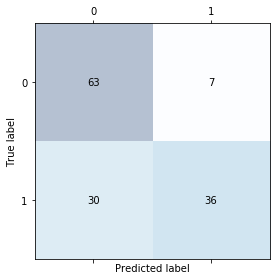

In [42]:
# Plotting of the confusion matrix and the ROC curve of the best regularized Logistic Regression model.
lr = LogisticRegression(C=Best_C, random_state=0)
lr.fit(X_train_std, y_train)

y_pred = lr.predict(X_test_std)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

1. 從我的 Confusion Matrix 可以發現：這次實驗的 Logistic Regression 整體的正確率是 $\frac{(63+36)}{(63+36+7+30)}\approx 0.73$，而錯誤率則是 $\frac{(7+30)}{(63+36+7+30)}\approx 0.27$。  
2. 其中，從我 predict 錯誤的 data 可以發現：$PRE=\frac{63}{63+30}\approx 0.68$，也就是說我 predict 是 $0$ 的 data 中，有大約三分之一是我誤將 $1$ predict 成 $0$ 的情況；不過根據 $REC=\frac{63}{63+7}=0.9 $，我能將九成的 ground truth 是 $0$ 的 labels 正確判斷出來。
從以上能得出，我的 $F_1=2\times \frac{PRE\times REC}{PRE+REC}\approx 0.78$  
3. 此外，由我 FP 和 FN 可以發現，我大部分的錯誤都集中在 FP ，也就是將 $1$ 誤認為 $0$ 的情況，代表我的 model 在這個判斷上有些問題。


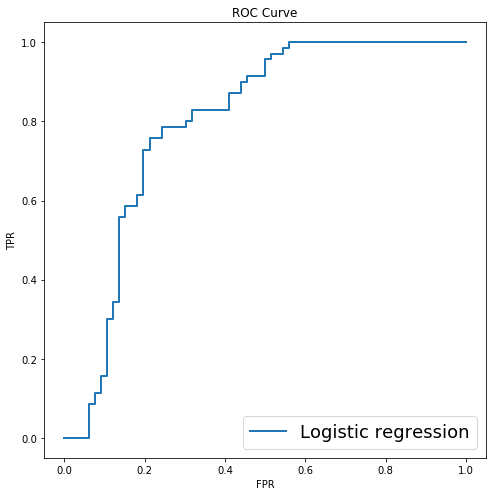

In [43]:
fig = plt.figure(figsize=(7,7))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

probas = lr.predict_proba(X_test_std)

fpr, tpr, thresholds = roc_curve(y_test,
                                 probas[:, 0],
                                 pos_label=0)
plt.plot(fpr, tpr, lw=2,
         label='Logistic regression')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.legend(loc=4, prop={'size': 18})
plt.show()

一個完美的 ROC 會是由左下到左上的一條垂直線，轉折成一個左上到右上的水平線；而一個亂猜的 ROC 則是一條對角線。  
從我的圖來觀察，可以看到我的圖形基本上比較接近前者，也就是比較好的 ROC。  
此外，根據 AUC 的結果，由於我的 AUC = 0.8，因此我的圖形應該要接近比較好的 ROC；實際觀察圖形後也確實如此。

In [44]:
# Save Image
lr = LogisticRegression(C=Best_C, random_state=0)
lr.fit(X_train_std, y_train)

y_pred = lr.predict(X_test_std)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,7))
ax1.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax1.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')


mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

probas = lr.predict_proba(X_test_std)

fpr, tpr, thresholds = roc_curve(y_test,
                                 probas[:, 0],
                                 pos_label=0)
plt.plot(fpr, tpr, lw=2,
         label='Logistic regression')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.legend(loc=4, prop={'size': 10})
plt.savefig('Lab6-106062541', dpi=300)